In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv1 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:05<00:00, 191.99it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 70:
        return 0.0001
    else:
        return 0.00001

In [10]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv1/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 129s 646ms/step - loss: 119.5895 - val_loss: 107.5510
Number of images: 1025
Presicion: 0.012
Recall: 0.1561
F1 score: 0.0223
F1 score: 0.022255618821040844
Improve F1 score from -inf to 0.022255618821040844
Epoch 2/100
200/200 [==============================] - 112s 559ms/step - loss: 107.4597 - val_loss: 106.7861
Number of images: 1025
Presicion: 0.014
Recall: 0.178
F1 score: 0.0259
F1 score: 0.025949110973929528
Improve F1 score from 0.022255618821040844 to 0.025949110973929528
Epoch 3/100
200/200 [==============================] - 113s 567ms/step - loss: 110.2785 - val_loss: 526226.5110


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] -

Number of images: 1025
Presicion: 0.0002
Recall: 0.0058
F1 score: 0.0004
F1 score: 0.0004355285849459122
Epoch 4/100
200/200 [==============================] - 114s 570ms/step - loss: 108.8831 - val_loss: 123.8342
Number of images: 1025
Presicion: 0.0247
Recall: 0.2375
F1 score: 0.0447
F1 score: 0.04470209956532777
Improve F1 score from 0.025949110973929528 to 0.04470209956532777
Epoch 5/100
200/200 [==============================] - 111s 557ms/step - loss: 109.3710 - val_loss: 137.2526
Number of images: 1025
Presicion: 0.0086
Recall: 0.1738
F1 score: 0.0165
F1 score: 0.016472913716781102
Epoch 6/100
200/200 [==============================] - 108s 538ms/step - loss: 85.1231 - val_loss: 1297575.5532
Number of images: 1025
Presicion: 0.0243
Recall: 0.099
F1 score: 0.039
F1 score: 0.039018634988945505
Epoch 7/100
200/200 [==============================] - 107s 533ms/step - loss: 36.6497 - val_loss: 1632.7361
Number of images: 1025
Presicion: 0.1261
Recall: 0.3251
F1 score: 0.1817
F1 score

Number of images: 1025
Presicion: 0.0399
Recall: 0.3282
F1 score: 0.0712
F1 score: 0.07120879861164414
Epoch 42/100
200/200 [==============================] - 108s 539ms/step - loss: 114.8885 - val_loss: 114.0511
Number of images: 1025
Presicion: 0.0725
Recall: 0.4314
F1 score: 0.1242
F1 score: 0.12417522571742816
Epoch 43/100
200/200 [==============================] - 109s 543ms/step - loss: 114.7552 - val_loss: 114.1446
Number of images: 1025
Presicion: 0.0431
Recall: 0.3291
F1 score: 0.0762
F1 score: 0.07624126277674372
Epoch 44/100
200/200 [==============================] - 108s 541ms/step - loss: 94.5087 - val_loss: 24.7686
Number of images: 1025
Presicion: 0.1333
Recall: 0.3165
F1 score: 0.1876
F1 score: 0.18758850703924468
Epoch 45/100
200/200 [==============================] - 108s 542ms/step - loss: 23.2906 - val_loss: 121.6824
Number of images: 1025
Presicion: 0.0507
Recall: 0.3604
F1 score: 0.0888
F1 score: 0.08883109959938425
Epoch 46/100
200/200 [==========================

200/200 [==============================] - 109s 544ms/step - loss: 106.5729 - val_loss: 106.4682
Number of images: 1025
Presicion: 0.0207
Recall: 0.1835
F1 score: 0.0372
F1 score: 0.03716185304128732
Epoch 81/100
200/200 [==============================] - 106s 530ms/step - loss: 106.8916 - val_loss: 108.3369
Number of images: 1025
Presicion: 0.0224
Recall: 0.1981
F1 score: 0.0403
F1 score: 0.04026616661798287
Epoch 82/100
200/200 [==============================] - 108s 540ms/step - loss: 106.7188 - val_loss: 106.5181
Number of images: 1025
Presicion: 0.0217
Recall: 0.2047
F1 score: 0.0393
F1 score: 0.03930509730603836
Epoch 83/100
200/200 [==============================] - 107s 533ms/step - loss: 106.6557 - val_loss: 106.4270
Number of images: 1025
Presicion: 0.0188
Recall: 0.178
F1 score: 0.0339
F1 score: 0.03394194243796122
Epoch 84/100
200/200 [==============================] - 108s 541ms/step - loss: 106.6158 - val_loss: 106.6566
Number of images: 1025
Presicion: 0.024
Recall: 0.21

200/200 [==============================] - 107s 533ms/step - loss: 4.4921 - val_loss: 4.5352
Number of images: 1025
Presicion: 0.0662
Recall: 0.5264
F1 score: 0.1176
F1 score: 0.11756536239827146
Epoch 19/100
200/200 [==============================] - 106s 531ms/step - loss: 4.4473 - val_loss: 4.4742
Number of images: 1025
Presicion: 0.0656
Recall: 0.5321
F1 score: 0.1168
F1 score: 0.11675263412670212
Epoch 20/100
200/200 [==============================] - 107s 535ms/step - loss: 4.4789 - val_loss: 4.6191
Number of images: 1025
Presicion: 0.0502
Recall: 0.5173
F1 score: 0.0915
F1 score: 0.09145362704492006
Epoch 21/100
200/200 [==============================] - 107s 535ms/step - loss: 4.4418 - val_loss: 4.4411
Number of images: 1025
Presicion: 0.0582
Recall: 0.5333
F1 score: 0.1049
F1 score: 0.10491757169059956
Epoch 22/100
200/200 [==============================] - 107s 533ms/step - loss: 4.3622 - val_loss: 4.3829
Number of images: 1025
Presicion: 0.0673
Recall: 0.5378
F1 score: 0.119

200/200 [==============================] - 107s 536ms/step - loss: 4.1234 - val_loss: 4.2028
Number of images: 1025
Presicion: 0.1128
Recall: 0.5234
F1 score: 0.1856
F1 score: 0.18558962327698003
Epoch 57/100
200/200 [==============================] - 109s 543ms/step - loss: 4.1144 - val_loss: 4.1930
Number of images: 1025
Presicion: 0.1007
Recall: 0.5124
F1 score: 0.1683
F1 score: 0.168254174207619
Epoch 58/100
200/200 [==============================] - 107s 536ms/step - loss: 4.1000 - val_loss: 4.2163
Number of images: 1025
Presicion: 0.0473
Recall: 0.5649
F1 score: 0.0873
F1 score: 0.08734676315654046
Epoch 59/100
200/200 [==============================] - 106s 531ms/step - loss: 4.0796 - val_loss: 4.2635
Number of images: 1025
Presicion: 0.0535
Recall: 0.556
F1 score: 0.0976
F1 score: 0.09757205054867403
Epoch 60/100
200/200 [==============================] - 108s 538ms/step - loss: 4.0647 - val_loss: 4.1347
Number of images: 1025
Presicion: 0.0823
Recall: 0.555
F1 score: 0.1433
F1

200/200 [==============================] - 108s 539ms/step - loss: 3.9413 - val_loss: 4.1049
Number of images: 1025
Presicion: 0.106
Recall: 0.5173
F1 score: 0.1759
F1 score: 0.1759269984678181
Epoch 96/100
200/200 [==============================] - 108s 538ms/step - loss: 3.9124 - val_loss: 4.0116
Number of images: 1025
Presicion: 0.0784
Recall: 0.5322
F1 score: 0.1367
F1 score: 0.13669439213398524
Epoch 97/100
200/200 [==============================] - 107s 537ms/step - loss: 4.0264 - val_loss: 4.2589
Number of images: 1025
Presicion: 0.0341
Recall: 0.5378
F1 score: 0.0641
F1 score: 0.06405410054799278
Epoch 98/100
200/200 [==============================] - 106s 530ms/step - loss: 3.9406 - val_loss: 4.0997
Number of images: 1025
Presicion: 0.1867
Recall: 0.4594
F1 score: 0.2655
F1 score: 0.26554925570419996
Improve F1 score from 0.23947811879701766 to 0.26554925570419996
Epoch 99/100
200/200 [==============================] - 109s 544ms/step - loss: 3.9502 - val_loss: 3.9374
Number o

200/200 [==============================] - 107s 533ms/step - loss: 4.5386 - val_loss: 4.5765
Number of images: 1025
Presicion: 0.1166
Recall: 0.4848
F1 score: 0.188
F1 score: 0.18796212153044697
Epoch 34/100
200/200 [==============================] - 107s 533ms/step - loss: 4.5275 - val_loss: 4.5805
Number of images: 1025
Presicion: 0.1028
Recall: 0.4834
F1 score: 0.1695
F1 score: 0.16947958185209708
Epoch 35/100
200/200 [==============================] - 107s 533ms/step - loss: 4.5306 - val_loss: 4.5827
Number of images: 1025
Presicion: 0.1019
Recall: 0.4901
F1 score: 0.1688
F1 score: 0.16877009991826136
Epoch 36/100
200/200 [==============================] - 108s 538ms/step - loss: 4.4782 - val_loss: 4.5528
Number of images: 1025
Presicion: 0.1201
Recall: 0.4631
F1 score: 0.1908
F1 score: 0.19076676256578043
Epoch 37/100
200/200 [==============================] - 107s 533ms/step - loss: 4.4885 - val_loss: 4.5146
Number of images: 1025
Presicion: 0.1154
Recall: 0.488
F1 score: 0.1866


200/200 [==============================] - 108s 540ms/step - loss: 4.2170 - val_loss: 4.2513
Number of images: 1025
Presicion: 0.0731
Recall: 0.5186
F1 score: 0.1281
F1 score: 0.1281169972127753
Epoch 73/100
200/200 [==============================] - 107s 533ms/step - loss: 4.1545 - val_loss: 4.2047
Number of images: 1025
Presicion: 0.077
Recall: 0.5436
F1 score: 0.1349
F1 score: 0.13491099671480275
Epoch 74/100
200/200 [==============================] - 109s 543ms/step - loss: 4.1827 - val_loss: 4.2139
Number of images: 1025
Presicion: 0.0714
Recall: 0.5454
F1 score: 0.1263
F1 score: 0.12630973038884766
Epoch 75/100
200/200 [==============================] - 107s 534ms/step - loss: 4.1689 - val_loss: 4.2061
Number of images: 1025
Presicion: 0.0696
Recall: 0.5534
F1 score: 0.1236
F1 score: 0.12359840921115002
Epoch 76/100
200/200 [==============================] - 106s 530ms/step - loss: 4.1864 - val_loss: 4.2150
Number of images: 1025
Presicion: 0.0674
Recall: 0.5407
F1 score: 0.1199


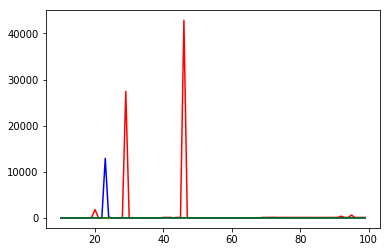

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

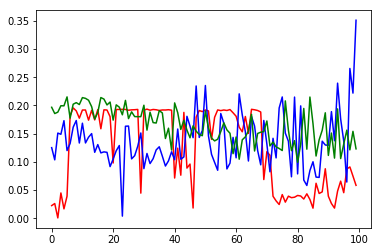

In [12]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
scale_factors = [1.5, 1.0, 0.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/shufflenet_v1_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/shufflenet_v1_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 684s 684ms/step - loss: 9.4477
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 616s 616ms/step - loss: 4.7836
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 567s 567ms/step - loss: 4.6395
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 563s 563ms/step - loss: 4.4467
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 566s 566ms/step - loss: 4.3176
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 565s 565ms/step - loss: 4.6294
Epoch 7/80

Epoch 00007: LearningRateS

1000/1000 [==============================] - 569s 569ms/step - loss: 3.5440
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 567s 567ms/step - loss: 3.5247
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 563s 563ms/step - loss: 3.5045
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 566s 566ms/step - loss: 3.4892
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 566s 566ms/step - loss: 3.9126
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 565s 565ms/step - loss: 3.5021
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 568s 568ms/step - l

1000/1000 [==============================] - 564s 564ms/step - loss: 4.0232
Epoch 26/80

Epoch 00026: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 560s 560ms/step - loss: 4.0178
Epoch 27/80

Epoch 00027: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 562s 562ms/step - loss: 3.9650
Epoch 28/80

Epoch 00028: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 560s 560ms/step - loss: 3.9498
Epoch 29/80

Epoch 00029: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 562s 562ms/step - loss: 3.9963
Epoch 30/80

Epoch 00030: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 562s 562ms/step - loss: 3.9185
Epoch 31/80

Epoch 00031: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 565s 565ms/step - l

Epoch 78/80

Epoch 00078: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 626s 626ms/step - loss: 3.4098
Epoch 79/80

Epoch 00079: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 568s 568ms/step - loss: 3.4002
Epoch 80/80

Epoch 00080: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 563s 563ms/step - loss: 3.3959
TRAINING MODEL WITH FACTOR: 0.5
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 570s 570ms/step - loss: 6.5526
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 562s 562ms/step - loss: 4.8939
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 561s 561ms/step - loss: 4.6782
Epoch 4/80

Epoch 00004: LearningRa

1000/1000 [==============================] - 557s 557ms/step - loss: 4.0065
Epoch 51/80

Epoch 00051: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 558s 558ms/step - loss: 4.1612
Epoch 52/80

Epoch 00052: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 557s 557ms/step - loss: 3.9884
Epoch 53/80

Epoch 00053: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 557s 557ms/step - loss: 3.8877
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 557s 557ms/step - loss: 3.8104
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 558s 558ms/step - loss: 3.7651
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 560s 560ms/step - l